In [52]:
import sys
sys.path.insert(0, '..')

In [53]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [54]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Version 4.4.1
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageH

In [55]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,
    "bias": {},
    "jitter": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([9., 5.])#*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [56]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [57]:
losses, models = optimise(params, model_single, exposures_single, things, 20)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[4050598.5, -650215.8],
       [-650216. , 4008933.5]], dtype=float32), 'spectrum': Array([[39020436.   ,  -348944.5  , 14256332.   ,  -178872.75 ,
         9415134.   ],
       [ -348945.2  ,  4738823.   ,  -196429.69 ,  3011463.5  ,
         -154753.31 ],
       [14256332.   ,  -196429.88 ,  6442466.   ,  -116312.625,
         4587756.5  ],
       [ -178873.19 ,  3011463.5  ,  -116312.75 ,  2261235.   ,
          -93522.44 ],
       [ 9415133.   ,  -154753.12 ,  4587756.5  ,   -93522.125,
         3430511.8  ]], dtype=float32), 'cold_mask_shift': Array([[-69311.39   ,    -82.65813],
       [   -82.6557 , -81816.21   ]], dtype=float32), 'cold_mask_rot': Array([[-134803.31]], dtype=float32)}}
Fitting Model


  0%|          | 0/20 [00:00<?, ?it/s]

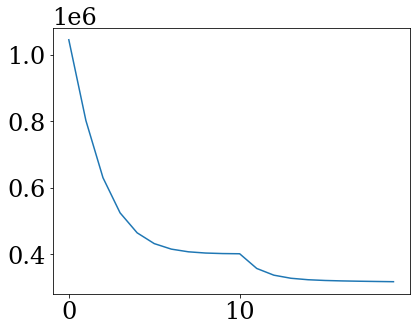

In [58]:
plt.plot(losses[-20:])

4


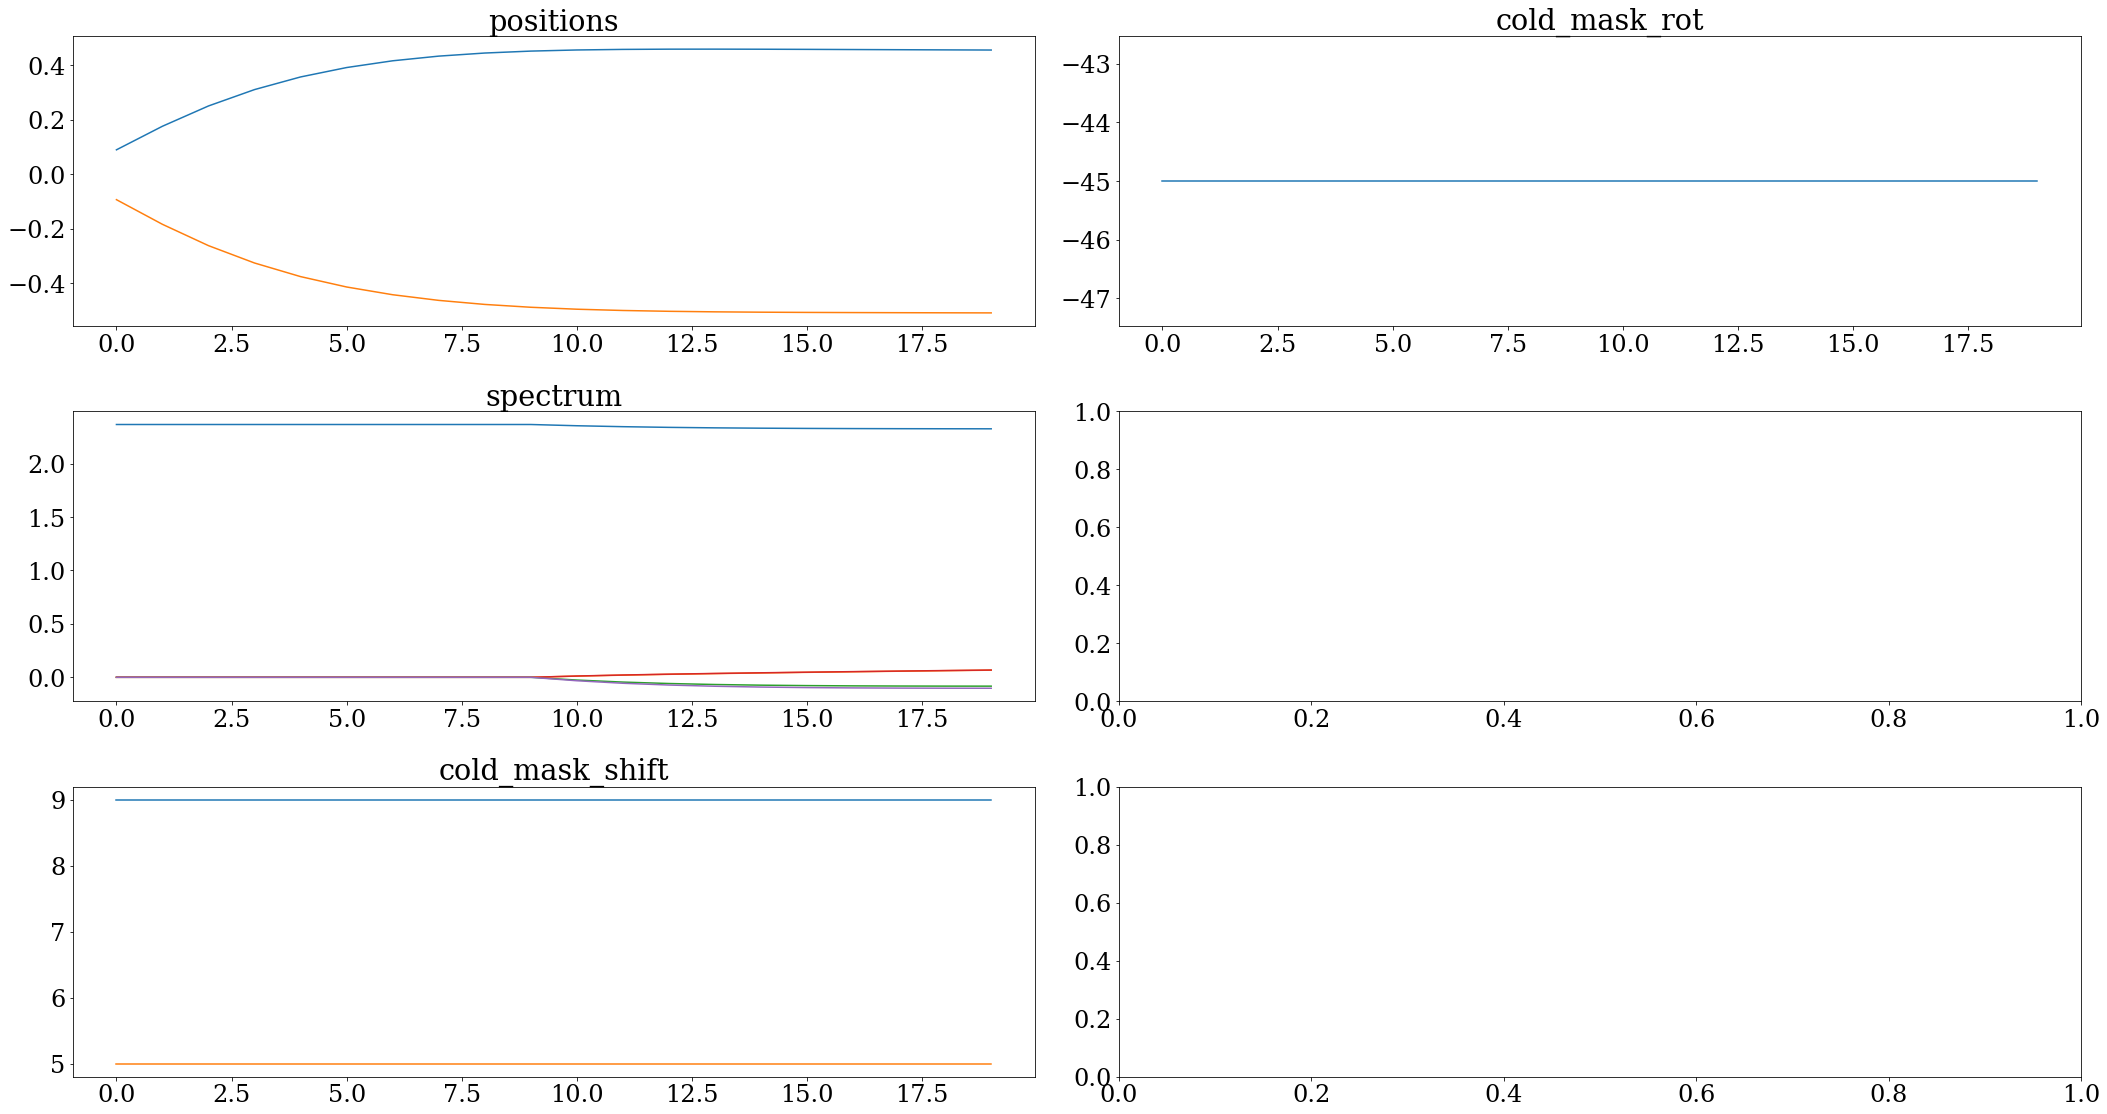

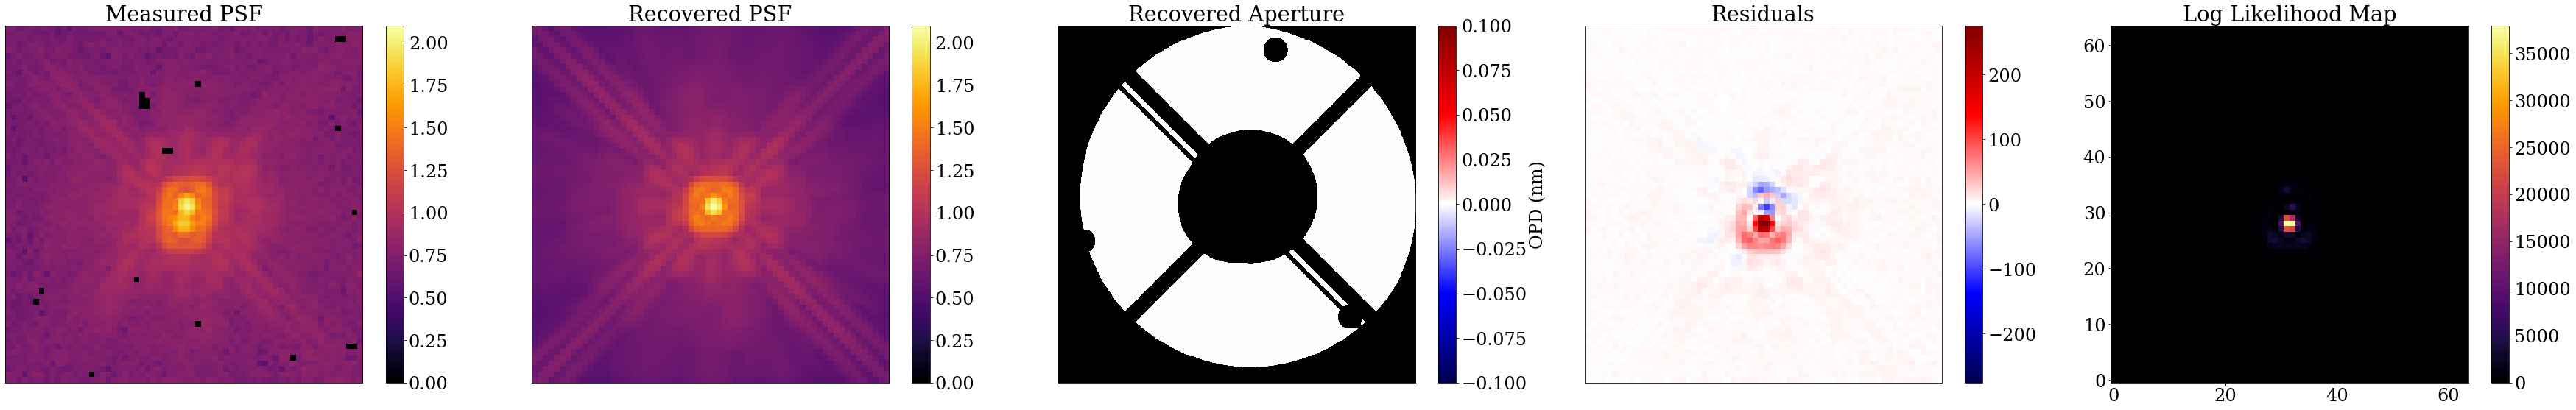

In [59]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [60]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)},
 'bias': {'n8yj59glq': 0.0},
 'cold_mask_rot': {'n8yj59glq': Array(-45., dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([9., 5.], dtype=float32)},
 'jitter': {'n8yj59glq': 0.6511627906976745},
 'outer_radius': 1.146,
 'positions': {'n8yj59glq': Array([ 0.45469156, -0.5077119 ], dtype=float32)},
 'primary_rot': {'F110W': 45.0},
 'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'primary_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'scale': 0.0432,
 'secondary_radius': 0.44639999999999996,
 'softening': 2.0,
 'spectrum': {'U20081_F110W': Array([ 2.3251276 ,  0.06672876, -0.08285675,  0.06793461, -0.10249525],      dtype=float32)},
 'spider_width': 0.0924}

In [61]:
#potato

In [62]:
#plot_spectra(model_single, models[-1], exposures_single)

In [63]:
psf = (exposures_single[0].data/np.nansum(exposures_single[0].data)).flatten()

psf= psf.at[np.isnan(psf)].set(0.)

actual = exposures_single[0].data.flatten()

actual = actual.at[np.isnan(actual)].set(0.)

design = np.transpose(np.vstack((np.ones(len(psf)), psf)))

#design.shape
bs, _, _, _ = np.linalg.lstsq(design, actual)


In [64]:
np.log10(bs[1]/20)

Array(2.365434, dtype=float32)

In [65]:
#stop

In [66]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [67]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [68]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [69]:

@zdx.filter_jit
def fit_binary_flux(params, exposures, x, y, theta, r, contrast):
    base_params = extract_binary_params(params, exposures, x, y, theta, r, 0., contrast)

    mdl = params.inject(model_binary)

    
    mean_flux = 0.

    for exp in exposures:

        #print(params.params["spectrum"])

        spec = params.get(exp.fit.map_param(exp, "spectrum"))[0]
        #print(spec)

        psf = exp.fit(mdl,exp).flatten()
        psf= np.where(exp.bad.flatten(), 0., psf)

        psf = psf/np.sum(psf)
        #psf.at[exp.bad.flatten()].set(0.)

        data = exp.data.flatten()
        #data= data.at[exp.bad.flatten()].set(0.)
        data= np.where(exp.bad.flatten(), 0., data)


        design = np.transpose(np.vstack((np.ones(len(psf)), psf)))

        flux_raw, _, _, _ = np.linalg.lstsq(design, data)
        
        true_flux= np.log10(flux_raw[1]/nwavels/(1+contrast)) - spec
        #print(true_flux)

        mean_flux += true_flux/len(exposures)
    
    flux_params = extract_binary_params(params, exposures, x, y, theta, r, mean_flux, contrast)

    return loss_fn(flux_params, exposures, model_binary), flux_params  



        

In [ ]:
#x_vals = np.linspace(-5, 5, 4)
#y_vals = np.linspace(-5, 5, 4)
theta_vals = np.linspace(0, 2*np.pi, 8)#np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.linspace(1,10,6)#np.asarray([1.5, 3])#np.linspace(0, 5, 2)
contrast_vals = np.linspace(0.2, 3, 6)

min_loss = np.inf
best_params = None

#for x in x_vals:
    #for y in y_vals:
for theta in theta_vals:
    for r in r_vals:
        for cnt in contrast_vals:
            x = r*np.cos(theta)/2
            y = r*np.sin(theta)/2
            loss, params = fit_binary_flux(models[-1], exposures_binary, x, y, theta, r, cnt)

            print(loss)
            if loss < min_loss and min_loss != 0.0:
                min_loss = loss
                best_params = params
        

959697.0
494142.62
550557.44
659109.1
760715.44
847514.1
5768841.5
2256756.8
1650569.8
1457034.8
1375221.9
1337341.2
9082254.0
3547518.2
2497336.5
2087472.5
1867759.8
1733412.5
13427722.0
4823400.0
3206354.5
2581431.5
2243721.0
2032676.8
45725700.0
16140132.0
10076841.0
7501969.0
6008554.0
5022059.0
121916920.0
40628370.0
23925192.0
17050432.0
13166557.0
10638517.0
575014.44
474857.44
589944.44
705477.25
803356.3
884600.0
2039495.8
2284017.2
2242348.5
2081645.0
1930808.2
1812694.6
4353954.0
3788864.2
3487678.5
3096827.5
2758166.5
2493380.8
9890296.0
12975812.0
12289921.0
10543958.0
8902826.0
7570208.5
14664282.0
20862926.0
19845134.0
16936526.0
14178080.0
11929387.0
20441996.0
33960196.0
32685186.0
27856434.0
23203388.0
19390736.0
488873.84
475509.12
603494.75
719765.0
816068.5
895485.5
1450212.6
2829013.0
2895318.8
2661165.8
2417233.5
2217719.8
2478701.8
5387476.0
5433941.0
4831426.0
4216975.0
3709458.2
7034533.0
18495444.0
18503548.0
16000978.0
13468968.0
11367785.0
10543137.0
277360

In [ ]:
min_loss, best_params.params

(Array(379028.88, dtype=float32),
 {'aberrations': {'n8yj59glq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)},
  'bias': {'n8yj59glq': 0.0},
  'cold_mask_rot': {'n8yj59glq': Array(-45., dtype=float32)},
  'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
  'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
  'cold_mask_shift': {'n8yj59glq': Array([9., 5.], dtype=float32)},
  'contrast': OrderedDict([('F110W', Array(0.90000004, dtype=float32))]),
  'fluxes': OrderedDict([('U20081_F110W', Array(-0.38553268, dtype=float32))]),
  'jitter': {'n8yj59glq': 0.6511627906976745},
  'outer_radius': 1.146,
  'position_angle': Array(4.1887903, dtype=float32),
  'positions': {'n8yj59glq': Array([-0.29530832, -1.80675   ], dtype=float32)},
  'primary_rot': {'F110W': 45.0},
  'primary_scale': {'F110W': Array([1., 1.], dtype=float32)},
  'primary_shear': {'F110W': Array([0., 0.], dtype=fl

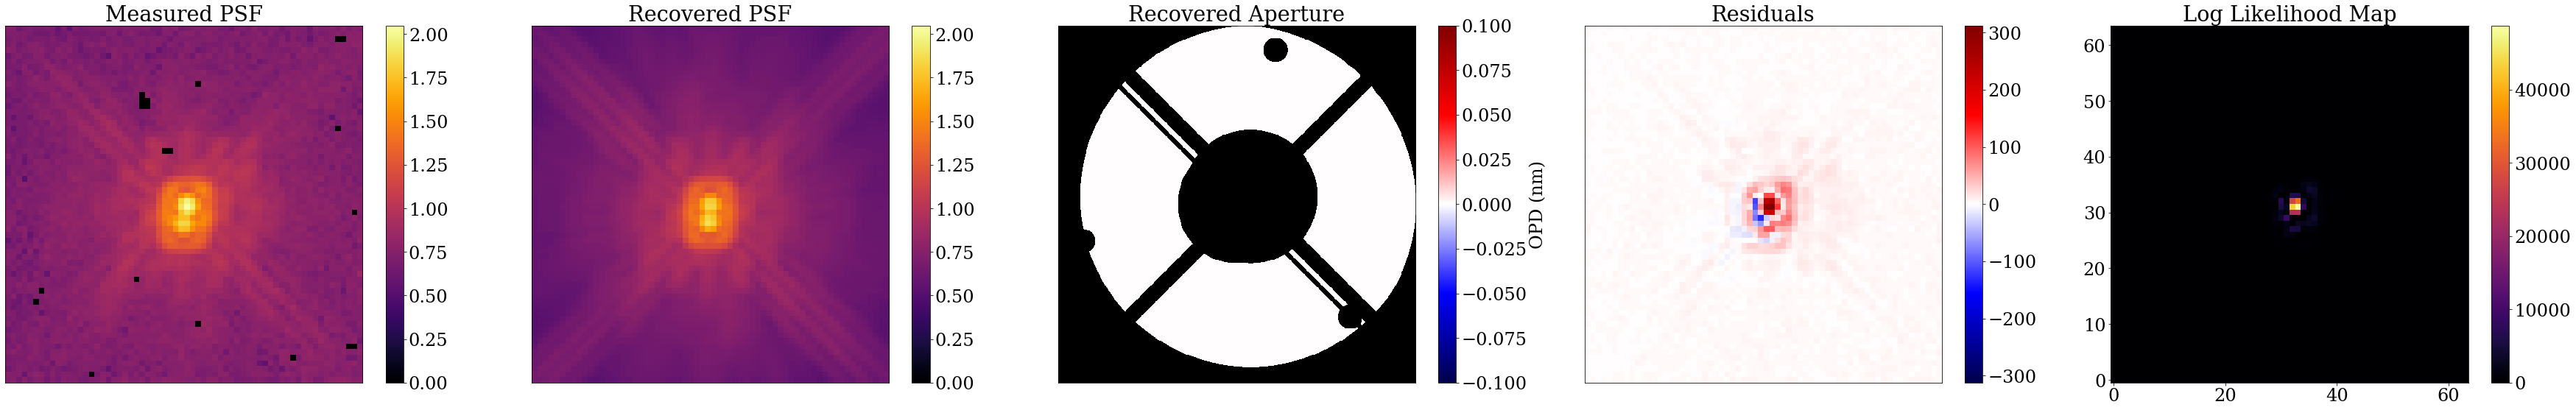

In [ ]:
plot_comparison(model_binary, best_params, exposures_binary)

In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-2, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*200, 60),
    "cold_mask_rot": opt(g*10, 60),
    "aberrations": opt(g*2,30),#, (150, g*0.2)),
    "bias": opt(g*20, 40)
}
groups = list(things.keys())


In [ ]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[6884428.5 , -251463.03],
       [-251463.33, 5561864.5 ]], dtype=float32), 'separation': Array([[-438152.75]], dtype=float32), 'position_angle': Array([[0.]], dtype=float32), 'primary_spectrum': Array([[28372474.  ,  1562966.9 ,  9263990.  ,  1192013.2 ,  5800337.5 ],
       [ 1562967.  ,  5021736.  ,   811615.3 ,  3084904.  ,   618378.3 ],
       [ 9263991.  ,   811615.3 ,  4432975.  ,   667450.75,  3169850.  ],
       [ 1192013.4 ,  3084904.  ,   667450.9 ,  2302695.5 ,   537777.4 ],
       [ 5800338.  ,   618378.6 ,  3169850.8 ,   537777.3 ,  2450654.2 ]],      dtype=float32), 'secondary_spectrum': Array([[28372474.  ,  1562966.9 ,  9263990.  ,  1192013.2 ,  5800337.5 ],
       [ 1562967.  ,  5021736.  ,   811615.3 ,  3084904.  ,   618378.3 ],
       [ 9263991.  ,   811615.3 ,  4432975.  ,   667450.75,  3169850.  ],
       [ 1192013.4 ,  3084904.  ,   667450.9 ,  2302695.5 ,   537777.4 ],
       [ 5800338.  ,   618378.6 ,  3169850.8 ,   537777.3 ,

  0%|          | 0/1000 [00:00<?, ?it/s]

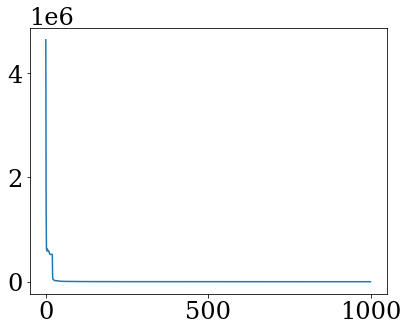

In [ ]:
plt.plot(losses)

9


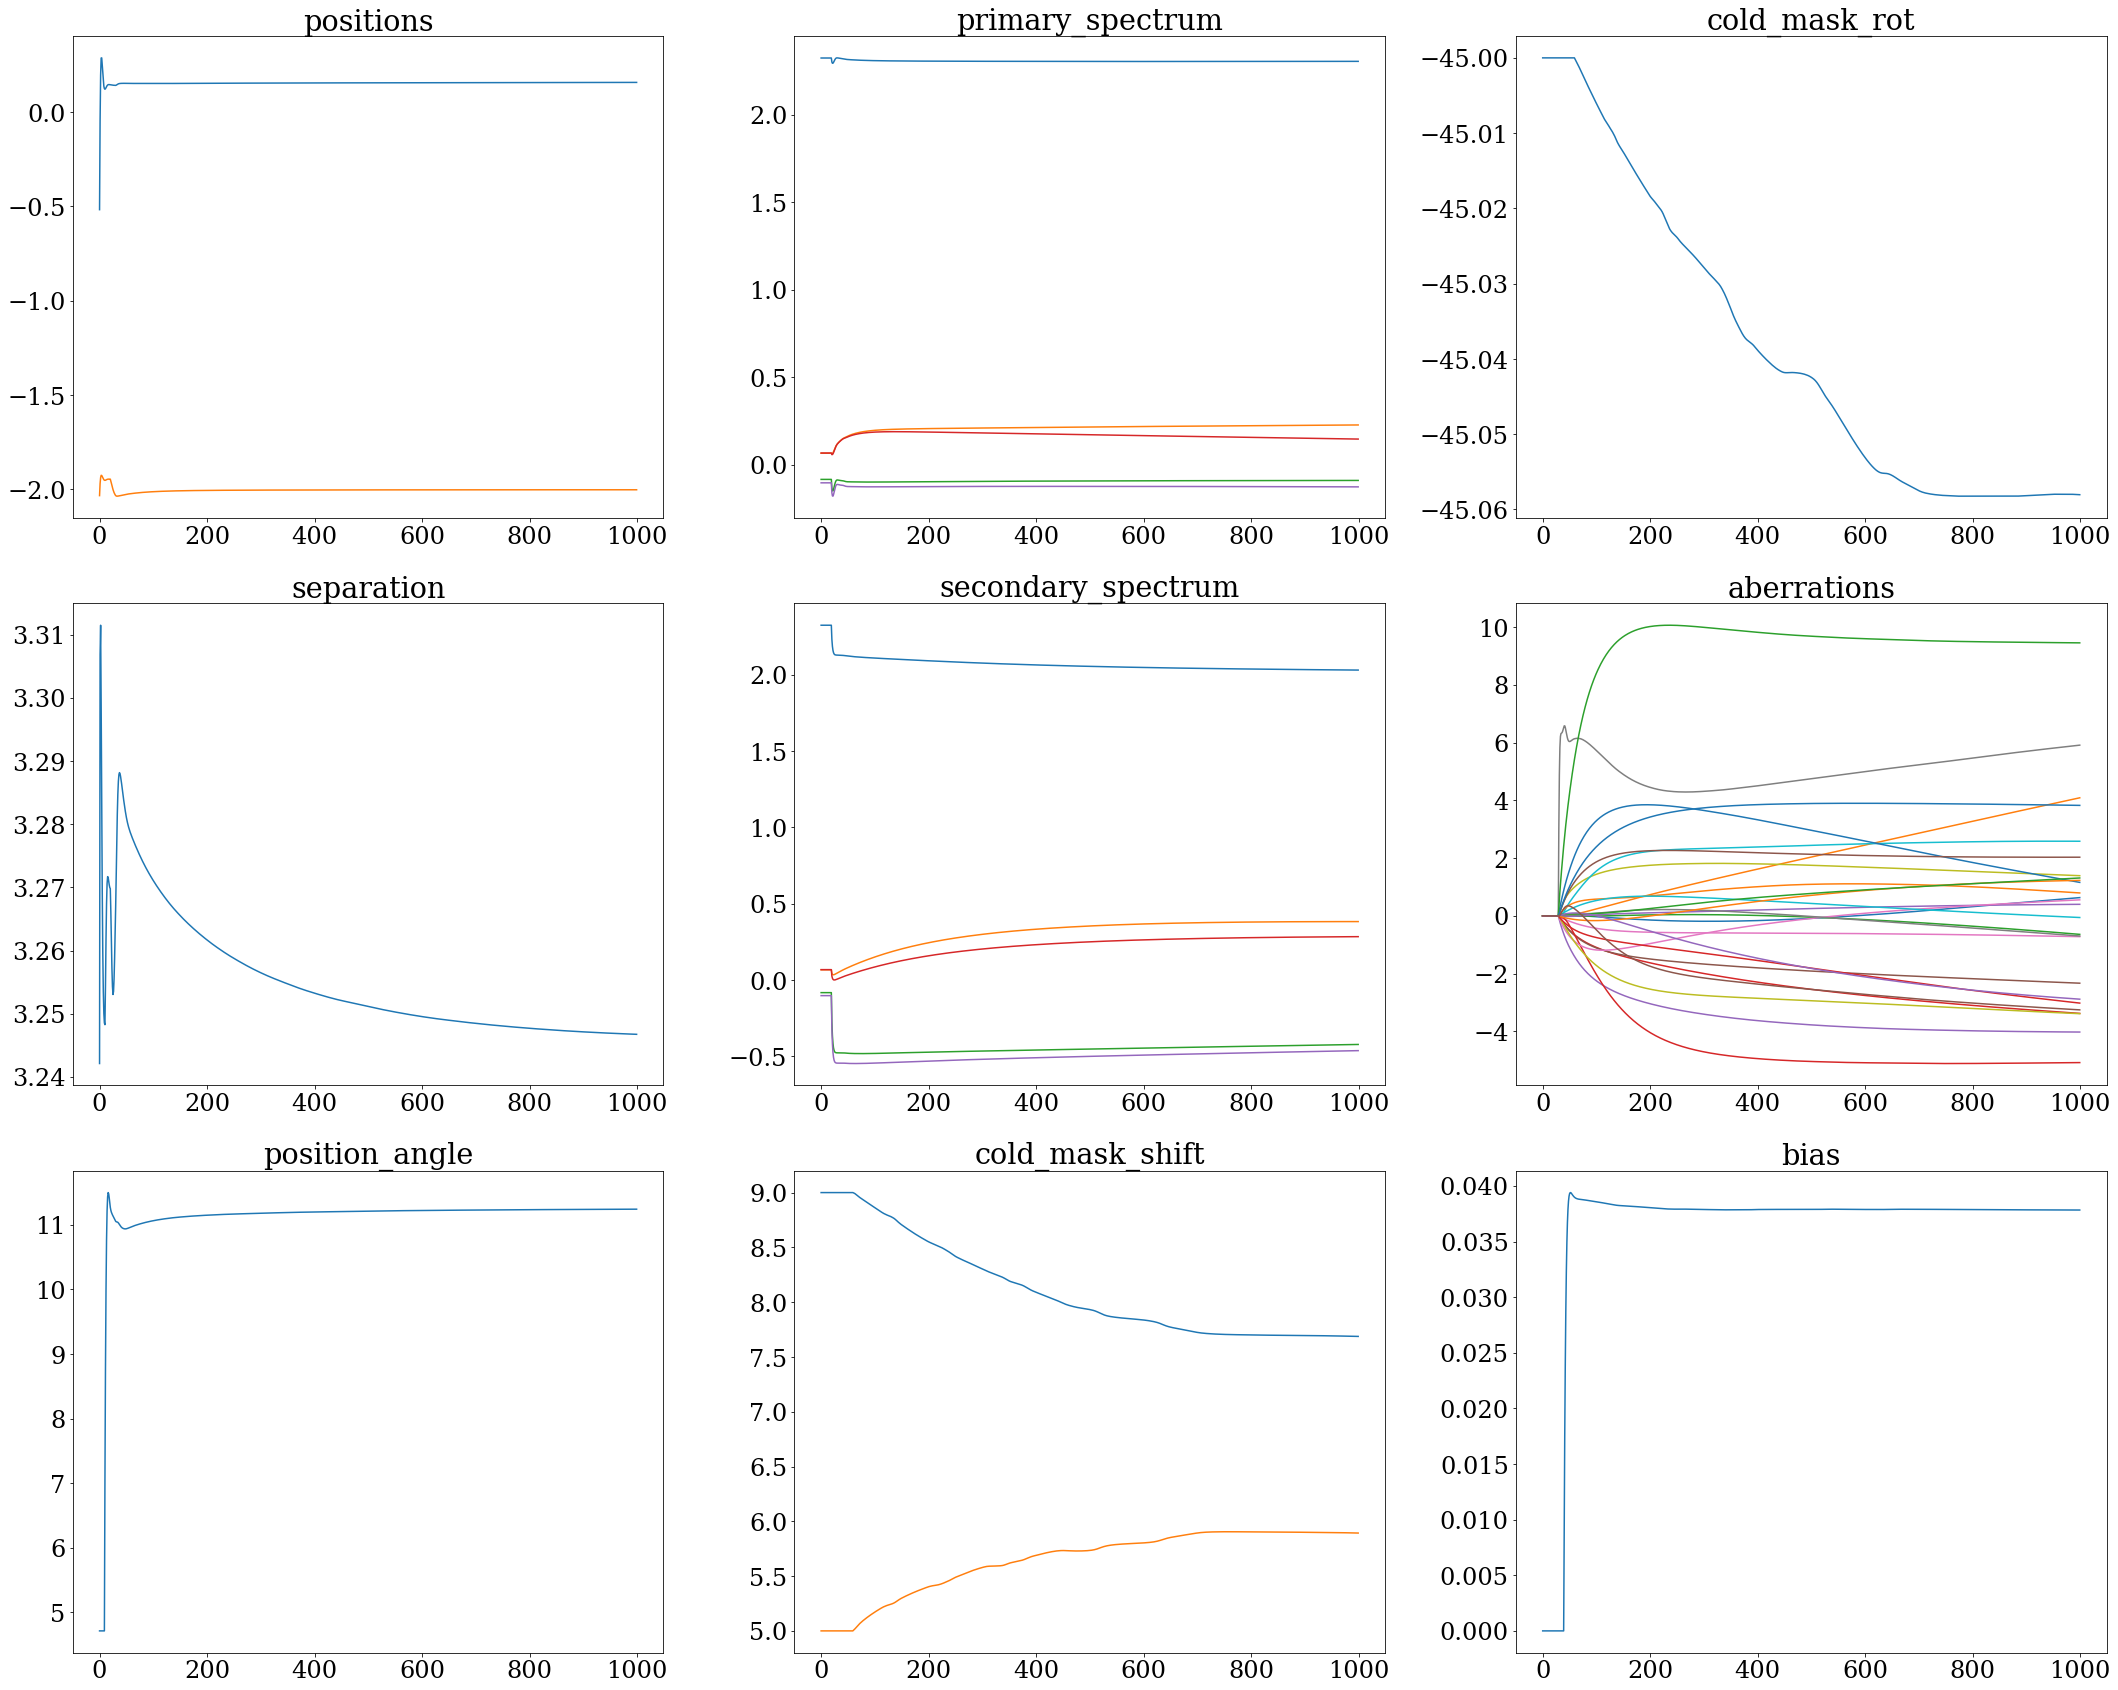

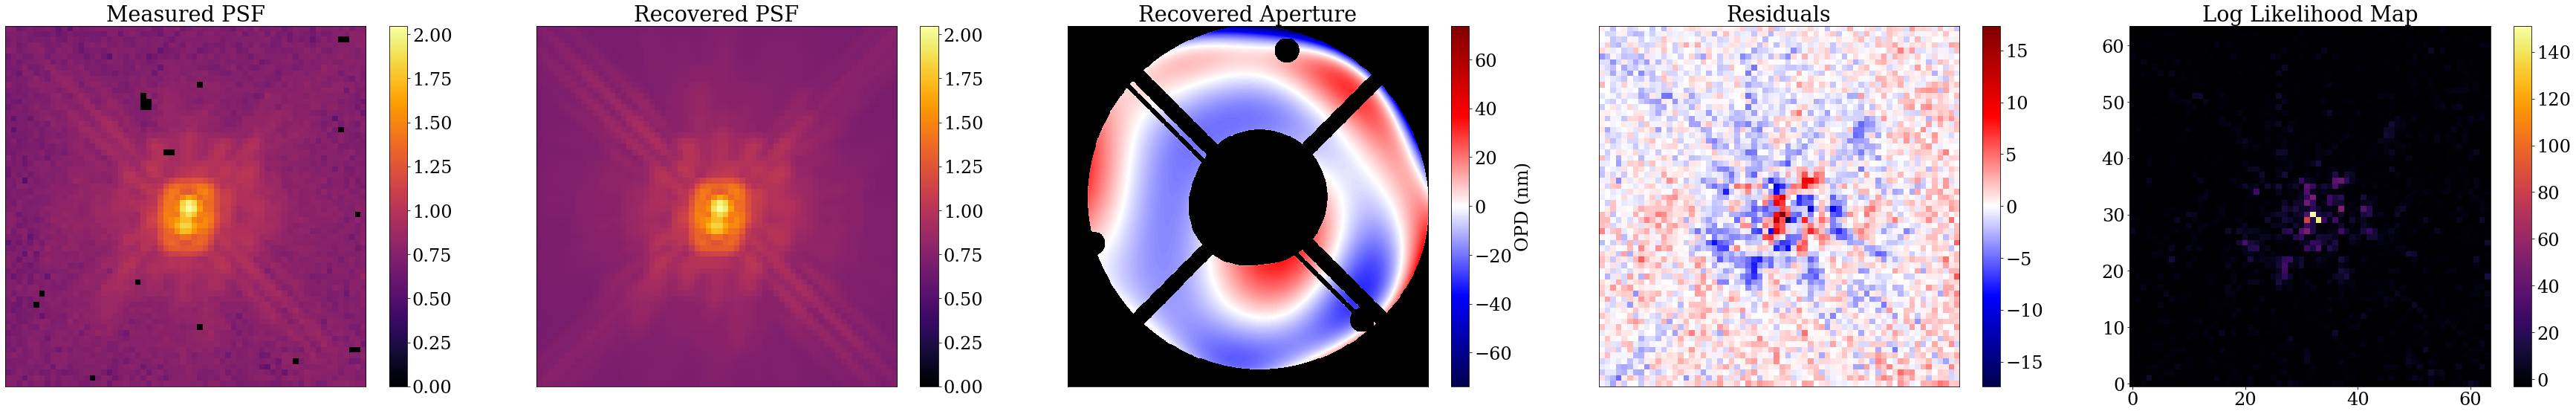

In [ ]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [ ]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ 0.631922  ,  4.0876527 , -0.6409875 , -3.3768086 , -4.0229907 ,
         -2.3313086 , -0.72013617,  5.910568  ,  1.3909254 ,  2.583142  ,
          1.1589681 ,  0.7929376 ,  9.452441  , -5.0805283 ,  0.3992762 ,
          2.0305305 ,  0.554083  , -0.6970362 , -3.3870375 , -0.05744915,
          3.8251443 ,  1.227672  ,  1.3115306 , -3.0206513 , -2.8848622 ,
         -3.2551312 ], dtype=float32)},
 'bias': {'n8yj59glq': Array(0.03783157, dtype=float32)},
 'cold_mask_rot': {'n8yj59glq': Array(-45.058037, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([7.687454 , 5.8928943], dtype=float32)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.07146072, dtype=float32))]),
 'jitter': {'n8yj59glq': 0.6511627906976745},
 'outer_radius': 1.146,
 'position_angle': Array(11.24334, dt

Text(0, 0.5, 'Relative Spectral Intensity')

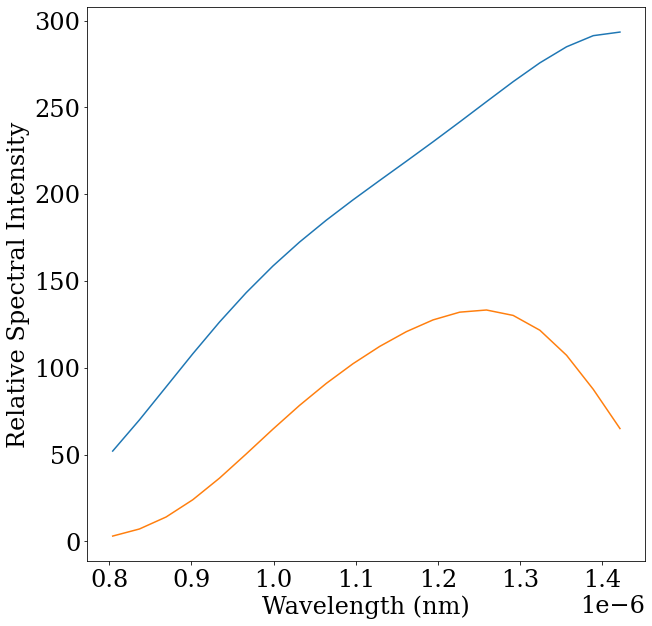

In [ ]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [ ]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [ ]:
models[-1]

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': f32[]},
    'cold_mask_rot':
    {'n8yj59glq': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f32[]},
    'jitter':
    {'n8yj59glq': 0.6511627906976745},
    'outer_radius':
    1.146,
    'position_angle':
    f32[],
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': 45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'separation':
    f32[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924
  }
)

In [ ]:
#jax.hessian(loss_fn)(models[-1], exposures_binary, model_binary)

KeyboardInterrupt: 

: 

In [ ]:
hessian = zdx.bayes.hessian(models[-1], groups, loss_fn, (exposures_binary, model_binary))

TypeError: Expected a callable value, got ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'bias':
    {'n8yj59glq': f32[]},
    'cold_mask_rot':
    {'n8yj59glq': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f32[]},
    'jitter':
    {'n8yj59glq': 0.6511627906976745},
    'outer_radius':
    1.146,
    'position_angle':
    f32[],
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': 45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'separation':
    f32[],
    'softening':
    2,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924
  }
)

In [ ]:
zdx.bayes.hessian

In [ ]:
covs = zdx.self_covariance_matrix(models[-1], )